# Análise IPTU vs ITBI - Imóveis de São Paulo

## Propósito

Este notebook realiza a análise comparativa entre os dados de IPTU (Imposto Predial e Territorial Urbano) e ITBI (Imposto sobre Transmissão de Bens Imóveis) para imóveis da cidade de São Paulo no período de 2019 a 2024. O objetivo principal é comparar o **Valor Venal** calculado pelo IPTU com o **Valor Real** das transações registradas no ITBI, identificando discrepâncias e padrões de avaliação imobiliária.

## Entradas (Inputs)

### Dados de IPTU
- **Arquivo CSV**: `data/IPTU_2019_2024.csv`
  - Dataset processado contendo dados de IPTU com Valor Venal calculado
  - Identificação por número do contribuinte e ano do exercício

### Dados de ITBI
- **Arquivo CSV**: `data/ITBI_2019_2024.csv`
  - Dataset consolidado de transações imobiliárias
  - Contém valores declarados pelos contribuintes e valores venais de referência
  - Identificação por número do cadastro SQL e data de transação

## Processamento Realizado

1. **Carregamento de Dados**: Carrega datasets de IPTU e ITBI
2. **Limpeza e Filtragem**: Filtra transações válidas (proporção transmitida = 100%, valores > 0)
3. **Cálculo de Valor Real**: Calcula o valor real da transação baseado na proporção transmitida
4. **Merge de Datasets**: Une dados de IPTU e ITBI por número do contribuinte e ano
5. **Análise Comparativa**: Calcula diferenças entre valor real e valor venal
6. **Visualizações**: Gera gráficos e estatísticas descritivas da comparação

## Saídas (Outputs)

- Análises estatísticas de correlação e covariância entre valores
- Visualizações de distribuição de diferenças
- Análises por faixas de valor
- Identificação de padrões de subavaliação ou superavaliação


In [ ]:
# Código comentado para montagem do Google Drive (usado apenas no Colab)
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# Código comentado para mudança de diretório (usado apenas no Colab)
#%cd drive/MyDrive/Projeto\ disciplina\ PCS5787
#!pwd

In [ ]:
# Importa biblioteca pandas para manipulação de dados
import pandas as pd

# Configura formato de exibição de números float para 2 casas decimais
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [ ]:
# Carrega dados de IPTU processados
df_iptu = pd.read_csv('data/IPTU_2019_2024.csv')

# Exibe informações sobre o dataset (tipos de dados, número de registros, etc.)
display(df_iptu.info())

C:\Users\cazev\AppData\Local\Temp\ipykernel_18308\376298294.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_iptu = pd.read_csv('data/IPTU_2019_2024.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21317311 entries, 0 to 21317310
Data columns (total 18 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   NUMERO DO CONTRIBUINTE        int64  
 1   ANO DO EXERCICIO              int64  
 2   NOME DE LOGRADOURO DO IMOVEL  object 
 3   NUMERO DO IMOVEL              float64
 4   AREA DO TERRENO               float64
 5   AREA CONSTRUIDA               float64
 6   AREA OCUPADA                  float64
 7   VALOR DO M2 DO TERRENO        int64  
 8   VALOR DO M2 DE CONSTRUCAO     int64  
 9   TIPO DE USO DO IMOVEL         object 
 10  TIPO DE PADRAO DA CONSTRUCAO  object 
 11  BAIRRO DO IMOVEL              object 
 12  CEP DO IMOVEL                 object 
 13  VALOR VENAL                   float64
 14  setor                         int64  
 15  quadra                        int64  
 16  lote                          int64  
 17  bairro                        object 
dtypes: float64(5), int64

None

In [ ]:
# Converte colunas de identificação para tipo object (string) para facilitar merge posterior
df_iptu["NUMERO DO CONTRIBUINTE"] = df_iptu["NUMERO DO CONTRIBUINTE"].astype("object")
df_iptu["ANO DO EXERCICIO"] = df_iptu["ANO DO EXERCICIO"].astype("object")

In [ ]:
# Exibe as primeiras linhas do dataset de IPTU para inspeção visual
df_iptu.head()

,NUMERO DO CONTRIBUINTE,ANO DO EXERCICIO,NOME DE LOGRADOURO DO IMOVEL,NUMERO DO IMOVEL,AREA DO TERRENO,AREA CONSTRUIDA,AREA OCUPADA,VALOR DO M2 DO TERRENO,VALOR DO M2 DE CONSTRUCAO,TIPO DE USO DO IMOVEL,TIPO DE PADRAO DA CONSTRUCAO,BAIRRO DO IMOVEL,CEP DO IMOVEL,VALOR VENAL,setor,quadra,lote,bairro
0,100300014,2019,R S CAETANO,13.00,136.00,135.00,108.00,2241,1668,Loja,Comercial horizontal - padrão B,SANTA EFIGENIA,01104-001,325195.24,1,3,1,NaN
1,100300022,2019,R S CAETANO,19.00,90.00,67.00,67.00,2241,1668,Loja,Comercial horizontal - padrão B,SANTA EFIGENIA,01104-001,197014.74,1,3,2,NaN
2,100300030,2019,R S CAETANO,27.00,105.00,140.00,84.00,2241,1668,Loja,Comercial horizontal - padrão B,SANTA EFIGENIA,01104-001,264429.29,1,3,3,NaN
3,100300049,2019,R S CAETANO,33.00,108.00,103.00,86.00,2241,1668,Loja,Comercial horizontal - padrão B,NaN,01104-001,257510.62,1,3,4,NaN
4,100300057,2019,R S CAETANO,39.00,120.00,98.00,96.00,2241,1668,Loja,Comercial horizontal - padrão B,NaN,01104-001,280637.04,1,3,5,NaN


## Carregamento e Preparação dos Dados de ITBI


In [ ]:
# Carrega dados de ITBI processados
df_itbi = pd.read_csv('data/ITBI_2019_2024.csv')

# Exibe informações sobre o dataset de ITBI
display(df_itbi.info())

C:\Users\cazev\AppData\Local\Temp\ipykernel_18308\4278850820.py:1: DtypeWarning: Columns (0,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_itbi = pd.read_csv('data/ITBI_2019_2024.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908503 entries, 0 to 908502
Data columns (total 20 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   N° do Cadastro (SQL)                              908503 non-null  object 
 1   Natureza de Transação                             908503 non-null  object 
 2   Valor de Transação (declarado pelo contribuinte)  908503 non-null  float64
 3   Data de Transação                                 908503 non-null  object 
 4   Valor Venal de Referência                         908503 non-null  float64
 5   Proporção Transmitida (%)                         908503 non-null  float64
 6   Valor Venal de Referência (proporcional)          908503 non-null  float64
 7   Base de Cálculo adotada                           908331 non-null  float64
 8   Tipo de Financiamento                             351401 non-null  object 
 9   Valo

None

In [ ]:
# Exibe as primeiras linhas do dataset de ITBI para inspeção visual
df_itbi.head()

,N° do Cadastro (SQL),Natureza de Transação,Valor de Transação (declarado pelo contribuinte),Data de Transação,Valor Venal de Referência,Proporção Transmitida (%),Valor Venal de Referência (proporcional),Base de Cálculo adotada,Tipo de Financiamento,Valor Financiado,Situação do SQL,Área do Terreno (m2),Área Construída (m2),Ano da Transacao,Mes da Transacao,Ano/Mes da Transacao,setor,quadra,lote,bairro
0,12310100659,1.Compra e venda,900000.00,02/01/2019,773836.00,100.00,773836.00,900000.00,1.Sistema Financeiro de Habitação,400000.00,Ativo Predial,49139,246,2019,1,2019/01,123,101,65,NaN
1,5528502403,1.Compra e venda,420000.00,02/01/2019,303832.00,100.00,303832.00,420000.00,1.Sistema Financeiro de Habitação,340721.07,Ativo Predial,5152,109,2019,1,2019/01,55,285,240,NaN
2,29903601032,1.Compra e venda,650000.00,03/01/2019,459364.00,100.00,459364.00,650000.00,NaN,0.00,Ativo Predial,1886,98,2019,1,2019/01,299,36,103,NaN
3,4201104559,1.Compra e venda,61765.36,03/01/2019,300840.00,100.00,300840.00,300840.00,NaN,0.00,Ativo Predial,1968,84,2019,1,2019/01,42,11,455,NaN
4,2206602970,1.Compra e venda,965000.00,03/01/2019,575501.00,100.00,575501.00,965000.00,NaN,0.00,Ativo Predial,1548,172,2019,1,2019/01,22,66,297,NaN


In [ ]:
# Converte colunas de identificação para tipo object (string) para facilitar merge posterior
df_itbi['N° do Cadastro (SQL)'] = df_itbi['N° do Cadastro (SQL)'].astype("object")
df_itbi['Ano da Transacao'] = df_itbi['Ano da Transacao'].astype("object")

## Limpeza e Filtragem dos Dados


In [ ]:
# Analisa a distribuição de valores da proporção transmitida
# Valores diferentes de 100% indicam transações parciais (ex: apenas uma fração do imóvel)
df_itbi['Proporção Transmitida (%)'].value_counts()



Proporção Transmitida (%)
100.00    598460
0.01       52829
50.00      25371
1.00       10744
0.02       10428
           ...  
42.66          1
54.09          1
65.91          1
52.68          1
16.14          1
Name: count, Length: 5874, dtype: int64

In [ ]:
# Filtra apenas transações com 100% de proporção transmitida
# Isso garante que estamos comparando valores de imóveis completos, não frações
df_itbi = df_itbi[df_itbi['Proporção Transmitida (%)'] == 100]

In [ ]:
# Remove registros com valor venal de referência inválido (zero ou negativo)
# Valores muito baixos podem indicar erros de cadastro ou transações atípicas
df_itbi = df_itbi[df_itbi['Valor Venal de Referência'] > 1]

In [ ]:
# Calcula o valor real da transação baseado na base de cálculo e proporção transmitida
# Como já filtramos para 100%, esta fórmula simplifica para: Base de Cálculo adotada
# Mantida a fórmula completa para consistência caso seja necessário ajustar filtros futuramente
df_itbi['VALOR REAL'] = df_itbi.apply(lambda row: row['Base de Cálculo adotada'] / row['Proporção Transmitida (%)'] * 100, axis=1)

# Remove registros com valor real inválido (zero ou negativo)
df_itbi = df_itbi[df_itbi['VALOR REAL'] > 1]

## Merge dos Datasets IPTU e ITBI


In [ ]:
# Realiza merge (junção) dos datasets de ITBI e IPTU
# Chaves de junção: número do cadastro/contribuinte e ano
# Inner join: mantém apenas registros que existem em ambos os datasets
# Sufixos diferenciam colunas com mesmo nome entre os datasets
df_merged = pd.merge(
        df_itbi,
        df_iptu,
        left_on=['N° do Cadastro (SQL)', 'Ano da Transacao'],
        right_on=['NUMERO DO CONTRIBUINTE', 'ANO DO EXERCICIO'],
        how='inner',
        suffixes=('_ITBI', '_IPTU')
    )

In [ ]:
# Exibe informações sobre o dataset mergeado
# Mostra número de registros que foram encontrados em ambos os datasets
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536306 entries, 0 to 536305
Data columns (total 39 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   N° do Cadastro (SQL)                              536306 non-null  object 
 1   Natureza de Transação                             536306 non-null  object 
 2   Valor de Transação (declarado pelo contribuinte)  536306 non-null  float64
 3   Data de Transação                                 536306 non-null  object 
 4   Valor Venal de Referência                         536306 non-null  float64
 5   Proporção Transmitida (%)                         536306 non-null  float64
 6   Valor Venal de Referência (proporcional)          536306 non-null  float64
 7   Base de Cálculo adotada                           536306 non-null  float64
 8   Tipo de Financiamento                             155912 non-null  object 
 9   Valo

In [ ]:
# Verifica se há registros sem correspondência após o merge
# Como usamos inner join, este resultado deve estar vazio (sem valores NaN)
df_merged[df_merged['NUMERO DO CONTRIBUINTE'].isna()][['N° do Cadastro (SQL)','Ano da Transacao','NUMERO DO CONTRIBUINTE', 'ANO DO EXERCICIO', 'VALOR VENAL']].head()

,N° do Cadastro (SQL),Ano da Transacao,NUMERO DO CONTRIBUINTE,ANO DO EXERCICIO,VALOR VENAL


In [ ]:
# Exibe os 10 registros com maiores valores reais de transação
# Útil para identificar transações de alto valor e verificar consistência dos dados
df_merged.sort_values(by='VALOR REAL', ascending=False).head(10)

,N° do Cadastro (SQL),Natureza de Transação,Valor de Transação (declarado pelo contribuinte),Data de Transação,Valor Venal de Referência,Proporção Transmitida (%),Valor Venal de Referência (proporcional),Base de Cálculo adotada,Tipo de Financiamento,Valor Financiado,...,VALOR DO M2 DE CONSTRUCAO,TIPO DE USO DO IMOVEL,TIPO DE PADRAO DA CONSTRUCAO,BAIRRO DO IMOVEL,CEP DO IMOVEL,VALOR VENAL,setor_IPTU,quadra_IPTU,lote_IPTU,bairro_IPTU
464594,29901102276,1.Compra e venda,729435080.10,22/12/2023,471245230.00,100.00,471245230.00,729435080.10,NaN,0.00,...,3998,"Prédio de escritório ou consultório, não em co...",Comercial vertical - padrão E,JD PAULISTA,04538-132,366509063.12,299,11,227,NaN
464592,29901102276,1.Compra e venda,729435080.10,22/12/2023,471245230.00,100.00,471245230.00,729435080.10,NaN,0.00,...,3998,"Prédio de escritório ou consultório, não em co...",Comercial vertical - padrão E,JD PAULISTA,04538-132,366509063.12,299,11,227,NaN
482186,8559110127,1.Compra e venda,385394373.40,31/05/2024,488407868.00,100.00,488407868.00,488407868.00,NaN,0.00,...,4169,"Outras edificações de uso comercial, com utili...",Comercial vertical - padrão E,NaN,04794-000,379771529.99,85,591,1012,NaN
33179,20005300469,1.Compra e venda,430000000.00,12/06/2019,430000000.00,100.00,430000000.00,430000000.00,NaN,0.00,...,4106,"Prédio de escritório ou consultório, não em co...",Comercial vertical - padrão E,NaN,05501-050,241140883.84,200,53,46,NaN
27100,20005300469,12.Dação em pagamento por escritura pública,430000000.00,23/05/2019,362478950.00,100.00,362478950.00,430000000.00,NaN,0.00,...,4106,"Prédio de escritório ou consultório, não em co...",Comercial vertical - padrão E,NaN,05501-050,241140883.84,200,53,46,NaN
154870,8215300154,1.Compra e venda,128988924.00,30/11/2020,354758017.00,100.00,354758017.00,354758017.00,NaN,0.00,...,1368,Indústria,Oficina/Posto de serviço/Armazém/Depósito/Indú...,JAGUARE,05322-900,178996342.88,82,153,15,NaN
406440,7809800027,1.Compra e venda,325000000.00,11/05/2023,157122301.00,100.00,157122301.00,325000000.00,NaN,0.00,...,1494,Armazéns gerais e depósitos,Oficina/Posto de serviço/Armazém/Depósito/Indú...,NaN,05118-100,122182577.04,78,98,2,NaN
147503,7329000019,12.Dação em pagamento por escritura pública,194856993.20,03/11/2020,319972536.00,100.00,319972536.00,319972536.00,NaN,0.00,...,3469,"Prédio de escritório, não em condomínio, de us...",Comercial vertical - padrão D,CASA VERDE,02511-000,225009142.41,73,290,1,NaN
60205,8565100790,1.Compra e venda,306807831.10,04/10/2019,242622515.00,100.00,242622515.00,306807831.10,NaN,0.00,...,4106,"Cinema, teatro, casa de diversão, clube ou con...",Comercial vertical - padrão E,ROQUE PETRONI JR.1464,04583-110,162704930.15,85,651,79,NaN
461893,9024900069,1.Compra e venda,272000000.00,15/12/2023,238786062.00,100.00,238786062.00,272000000.00,NaN,0.00,...,1953,Indústria,Indústria - padrão E,SANTO AMARO,04660-907,185693658.47,90,249,6,NaN


## Análise Estatística e Visualizações


In [ ]:
# Importa biblioteca seaborn para visualizações estatísticas avançadas
import seaborn as sns


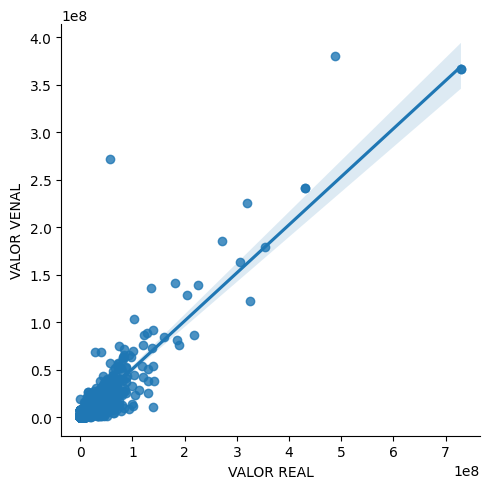

In [ ]:
# Cria gráfico de dispersão com linha de regressão linear
# Compara Valor Real (transação) vs Valor Venal (IPTU)
# A linha de regressão mostra a tendência de correlação entre os valores
sns.lmplot(x='VALOR REAL', y='VALOR VENAL', data=df_merged)

In [ ]:
# Calcula matriz de covariância entre Valor Real e Valor Venal
# Covariância positiva indica que valores tendem a variar na mesma direção
df_merged[["VALOR REAL","VALOR VENAL"]].cov()

,VALOR REAL,VALOR VENAL
VALOR REAL,8500528803562.48,4299885017871.41
VALOR VENAL,4299885017871.41,2595721324418.05


In [ ]:
# Calcula matriz de correlação entre Valor Real e Valor Venal
# Correlação próxima de 1 indica forte relação linear positiva
# Valores entre -1 e 1, onde 1 = correlação perfeita positiva
df_merged[["VALOR REAL","VALOR VENAL"]].corr()

,VALOR REAL,VALOR VENAL
VALOR REAL,1.00,0.92
VALOR VENAL,0.92,1.00


## Cálculo de Diferenças e Análise por Faixas de Valor


In [ ]:
# Calcula diferença absoluta entre Valor Real e Valor Venal
# Valores positivos indicam que o valor real é maior que o venal (subavaliação do IPTU)
# Valores negativos indicam que o valor venal é maior que o real (superavaliação do IPTU)
df_merged['DIFERENCA VALOR'] = df_merged.apply(lambda row: (row['VALOR REAL'] - row['VALOR VENAL']), axis=1)

# Calcula diferença percentual (normalizada pelo valor real)
# Facilita comparação entre imóveis de diferentes faixas de valor
df_merged['DIFERENCA VALOR PERC'] = df_merged.apply(lambda row: (row['DIFERENCA VALOR']/row['VALOR REAL']), axis=1)


In [ ]:
# Define função para classificar imóveis em faixas de valor
# Facilita análise comparativa por segmento de mercado
def get_faixa(val):
  if val < 100000:
    return '1 - 0-100k'
  elif val < 200000:
    return '2- 100k-200k'
  elif val < 300000:
    return '3 - 200k-300k'
  elif val < 400000:
    return '4 - 300k-400k'
  elif val < 500000:
    return '5 - 400k-500k'
  elif val < 1000000:
    return '6 - 500k-1M'
  elif val < 5000000:
    return '7 - 1M-5M'
  else:
    return '8 - 5M+'

# Aplica função para criar coluna de faixa de valor
df_merged['FAIXA VALOR'] = df_merged.apply(lambda row: get_faixa(row['VALOR REAL']), axis=1)

<Axes: xlabel='DIFERENCA VALOR', ylabel='Count'>

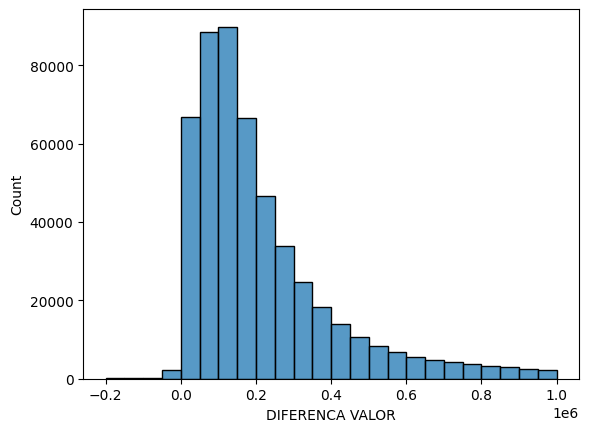

In [ ]:
# Histograma da distribuição de diferenças absolutas
# Mostra quantas transações têm diferenças em cada intervalo
# Valores positivos = subavaliação do IPTU, negativos = superavaliação
sns.histplot(data=df_merged, x="DIFERENCA VALOR", binwidth=50000, binrange=(-200000,1000000))

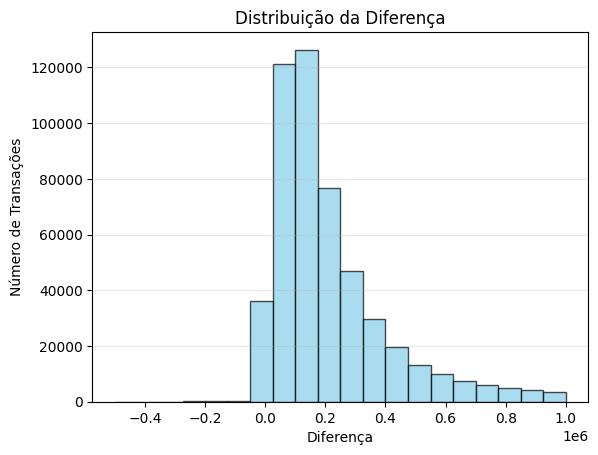

In [ ]:
# Importa matplotlib para customização de gráficos
import matplotlib.pyplot as plt

# Histograma customizado da distribuição de diferenças
# Usa matplotlib para maior controle sobre aparência do gráfico
df_merged['DIFERENCA VALOR'].plot.hist(
    bins=20,                 # número de intervalos (bins)
    range=(-500000, 1000000),    # faixa do eixo x (limites mínimo e máximo)
    color='skyblue',         # cor das barras
    edgecolor='black',       # cor da borda das barras
    alpha=0.7                # nível de transparência (0 = transparente, 1 = opaco)
)

plt.title('Distribuição da Diferença entre Valor Real e Valor Venal')
plt.xlabel('Diferença (R$)')
plt.ylabel('Número de Transações')
plt.grid(axis='y', alpha=0.3)  # adiciona grade no eixo y para facilitar leitura
plt.show()

<Axes: xlabel='DIFERENCA VALOR PERC', ylabel='Count'>

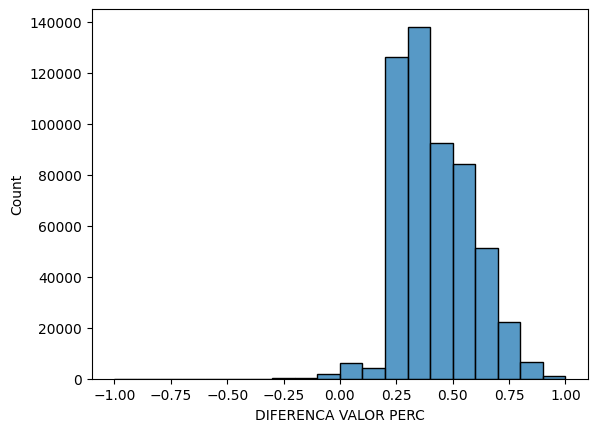

In [ ]:
# Histograma da distribuição de diferenças percentuais
# Normaliza diferenças pelo valor real, permitindo comparação entre diferentes faixas
# Valores entre -1 e 1 representam diferenças de -100% a +100%
sns.histplot(data=df_merged, x="DIFERENCA VALOR PERC", binwidth=0.1, binrange=(-1,1))

C:\Users\cazev\AppData\Local\Temp\ipykernel_18308\2494786962.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


[Text(0, 0, '1 - 0-100k'),
 Text(1, 0, '2- 100k-200k'),
 Text(2, 0, '3 - 200k-300k'),
 Text(3, 0, '4 - 300k-400k'),
 Text(4, 0, '5 - 400k-500k'),
 Text(5, 0, '6 - 500k-1M'),
 Text(6, 0, '7 - 1M-5M'),
 Text(7, 0, '8 - 5M+')]

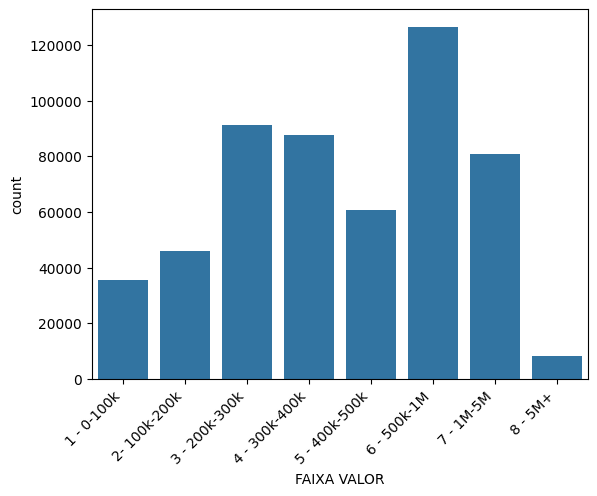

In [ ]:
# Gráfico de barras mostrando quantidade de transações por faixa de valor
# Ordena faixas numericamente para melhor visualização
ax = sns.countplot(df_merged, x="FAIXA VALOR", order=sorted(df_merged['FAIXA VALOR'].unique()))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')  # rotaciona labels para melhor legibilidade


C:\Users\cazev\AppData\Local\Temp\ipykernel_18308\3465513052.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


[Text(0, 0, '1 - 0-100k'),
 Text(1, 0, '2- 100k-200k'),
 Text(2, 0, '3 - 200k-300k'),
 Text(3, 0, '4 - 300k-400k'),
 Text(4, 0, '5 - 400k-500k'),
 Text(5, 0, '6 - 500k-1M'),
 Text(6, 0, '7 - 1M-5M'),
 Text(7, 0, '8 - 5M+')]

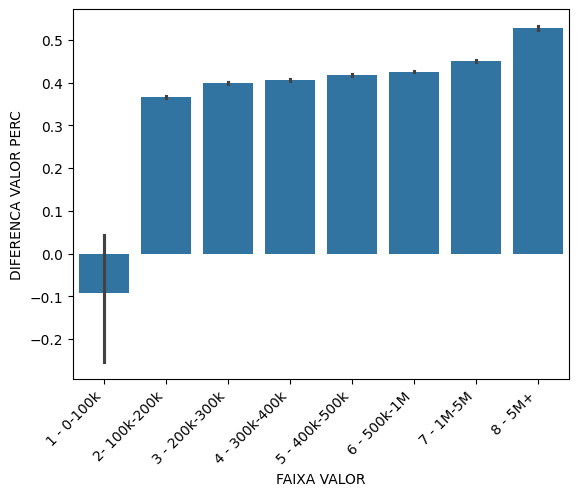

In [ ]:
# Gráfico de barras mostrando diferença percentual média por faixa de valor
# Permite identificar se há padrões de subavaliação/superavaliação por segmento
# Código comentado mostra alternativa usando groupby para calcular médias manualmente
# df_faixa = df_merged.groupby('FAIXA VALOR')['DIFERENCA VALOR PERC'].mean()

ax = sns.barplot(df_merged, x="FAIXA VALOR", y="DIFERENCA VALOR PERC", order=sorted(df_merged['FAIXA VALOR'].unique()))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')  # rotaciona labels para melhor legibilidade

C:\Users\cazev\AppData\Local\Temp\ipykernel_18308\3423639334.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


[Text(0, 0, '1 - 0-100k'),
 Text(1, 0, '2- 100k-200k'),
 Text(2, 0, '3 - 200k-300k'),
 Text(3, 0, '4 - 300k-400k'),
 Text(4, 0, '5 - 400k-500k'),
 Text(5, 0, '6 - 500k-1M'),
 Text(6, 0, '7 - 1M-5M'),
 Text(7, 0, '8 - 5M+')]

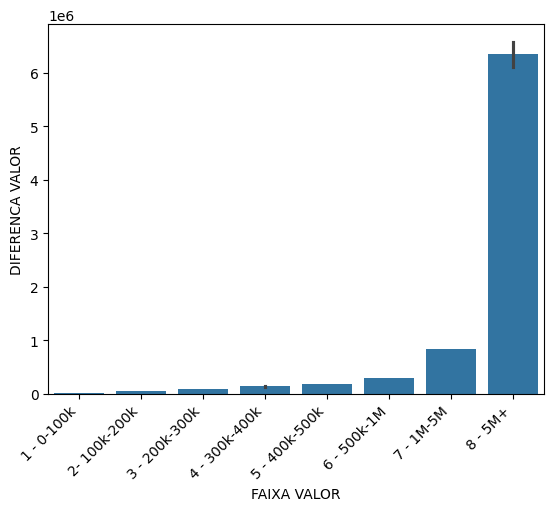

In [ ]:
# Gráfico de barras mostrando diferença absoluta média por faixa de valor
# Complementa análise percentual mostrando valores absolutos em reais
ax = sns.barplot(df_merged, x="FAIXA VALOR", y="DIFERENCA VALOR", order=sorted(df_merged['FAIXA VALOR'].unique()))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')  # rotaciona labels para melhor legibilidade

In [ ]:
# Verifica se há registros com valor venal de referência inválido após o merge
# Deve retornar vazio já que filtramos anteriormente, mas serve como validação
df_merged[df_merged['Valor Venal de Referência'] < 1]

,N° do Cadastro (SQL),Natureza de Transação,Valor de Transação (declarado pelo contribuinte),Data de Transação,Valor Venal de Referência,Proporção Transmitida (%),Valor Venal de Referência (proporcional),Base de Cálculo adotada,Tipo de Financiamento,Valor Financiado,...,BAIRRO DO IMOVEL,CEP DO IMOVEL,VALOR VENAL,setor_IPTU,quadra_IPTU,lote_IPTU,bairro_IPTU,DIFERENCA VALOR,DIFERENCA VALOR PERC,FAIXA VALOR
